# Analyzing King County Home Sales

In [2]:
# Standard Packages
import pandas as pd
import numpy as np

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Scipy Stats
import scipy.stats as stats 

# Statsmodel Api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# SKLearn Modules
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, f_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Notebook Options
import warnings
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
pd.reset_option("display.max_rows")

In [5]:
# Import king county housing sales and inspect
house_data_df = pd.read_csv('../data/kc_house_data.csv')
house_data_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188


In [ ]:
# Look at statistics for numerical columns
house_data_df.describe()

In [ ]:
# Check for Missing Values and Dtypes
house_data_df.info()

In [6]:
# Drop the handful of rows missing values for 'heat_source' & 'sewer_system'
house_data_df = house_data_df.dropna()
house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30111 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30111 non-null  int64  
 1   date           30111 non-null  object 
 2   price          30111 non-null  float64
 3   bedrooms       30111 non-null  int64  
 4   bathrooms      30111 non-null  float64
 5   sqft_living    30111 non-null  int64  
 6   sqft_lot       30111 non-null  int64  
 7   floors         30111 non-null  float64
 8   waterfront     30111 non-null  object 
 9   greenbelt      30111 non-null  object 
 10  nuisance       30111 non-null  object 
 11  view           30111 non-null  object 
 12  condition      30111 non-null  object 
 13  grade          30111 non-null  object 
 14  heat_source    30111 non-null  object 
 15  sewer_system   30111 non-null  object 
 16  sqft_above     30111 non-null  int64  
 17  sqft_basement  30111 non-null  int64  
 18  sqft_g

In [7]:
# Drop row where 3ft living space is clearly a data entry error
house_data_df = house_data_df.drop(index=(house_data_df[house_data_df['sqft_living'] == 3].index.values))

In [9]:
# Filter dataset to houses priced between $250k and $15mm per stakeholder instructions in business case
house_data_df = house_data_df.loc[(house_data_df['price'] >= 250000) & (house_data_df['price'] <= 15000000)]
house_data_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,NONE,Average,8 Good,Gas,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [10]:
# Drop id column
house_data_df = house_data_df.drop(columns='id',axis=1)

In [11]:
# Check yr_renovated column
house_data_df['yr_renovated'].value_counts()

0       28355
2021       69
2006       48
2018       43
2004       41
        ...  
1972        1
1946        1
1947        1
1966        1
1924        1
Name: yr_renovated, Length: 81, dtype: int64

In [12]:
# Convert yr_renovated to boolean column titled renovated
house_data_df['renovated'] = house_data_df['yr_renovated'].astype('bool')
house_data_df['renovated'].value_counts()

False    28355
True      1344
Name: renovated, dtype: int64

In [13]:
# Drop yr_renovated and convert boolean values to int
house_data_df = house_data_df.drop(columns='yr_renovated')
house_data_df['renovated'] = house_data_df['renovated'].astype(int)
house_data_df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,address,lat,long,renovated
0,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,0
1,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,0
2,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,0
3,12/14/2021,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,0
4,8/24/2021,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,11/30/2021,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,1600,1130,0,210,1921,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940,0
30151,6/16/2021,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,2020,0,0,520,2011,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851,0
30152,5/27/2022,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,940,920,240,110,1995,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585,0
30153,2/24/2022,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,NONE,Average,8 Good,Gas,PUBLIC,1830,740,480,100,2006,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908,0


In [14]:
# Convert date column to datetime and extract month and year
house_data_df['date'] = pd.to_datetime(house_data_df['date'], format='%m/%d/%Y')

house_data_df['month'] = house_data_df['date'].dt.month
house_data_df['year'] = house_data_df['date'].dt.year

# Delete origninal date column
house_data_df = house_data_df.drop(columns='date')
house_data_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,address,lat,long,renovated,month,year
0,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40,1969,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,0,5,2022
1,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,Oil,PUBLIC,1570,1570,0,240,1950,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,0,12,2021
2,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,Gas,PUBLIC,1580,1580,0,0,1956,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,0,9,2021
3,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,AVERAGE,Average,9 Better,Gas,PUBLIC,1090,1070,200,270,2010,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,0,12,2021
4,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,NONE,Average,7 Average,Electricity,PUBLIC,1120,550,550,30,2012,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,0,8,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,NONE,Good,8 Good,Oil,PUBLIC,1600,1130,0,210,1921,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940,0,11,2021
30151,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,FAIR,Average,7 Average,Gas,PUBLIC,2020,0,0,520,2011,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851,0,6,2021
30152,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,NONE,Average,7 Average,Gas,PUBLIC,940,920,240,110,1995,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585,0,5,2022
30153,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,NONE,Average,8 Good,Gas,PUBLIC,1830,740,480,100,2006,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908,0,2,2022


In [15]:
# Create new df column to hold extracted zip codes and drop address
house_data_df['zip'] = house_data_df['address'].str[-20:-15]
house_data_df = house_data_df.drop(columns='address', axis = 1)

In [ ]:
# Check zip code unique values
house_data_df['zip'].value_counts()

In [17]:
# Import zip code data from county website to filter incorrect data out
kc_zip_codes = pd.read_csv('../data/king-co-zip-table.csv')
kc_zip_codes

,ZIPCODE,COUNTY,COUNTY_NAME,PREFERRED_CITY
0,98001,33,King County,AUBURN
1,98002,33,King County,AUBURN
2,98003,33,King County,FEDERAL WAY
3,98004,33,King County,BELLEVUE
4,98005,33,King County,BELLEVUE
...,...,...,...,...
204,98940,37,Kittitas County,RONALD
205,98941,37,Kittitas County,ROSLYN
206,98943,37,Kittitas County,SOUTH CLE ELUM
207,98946,37,Kittitas County,THORP


In [ ]:
# Count unique zip codes
kc_zip_codes.nunique()

In [18]:
# Convert 'ZIPCODE' to string and store in list
zip_str_list = kc_zip_codes['ZIPCODE'].astype(str)

In [19]:
# Compare county zip list to housing sales df and remove rows containing erroneous address info
mask = house_data_df['zip'].isin(zip_str_list)
house_data_df = house_data_df[mask]
house_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28788 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          28788 non-null  float64
 1   bedrooms       28788 non-null  int64  
 2   bathrooms      28788 non-null  float64
 3   sqft_living    28788 non-null  int64  
 4   sqft_lot       28788 non-null  int64  
 5   floors         28788 non-null  float64
 6   waterfront     28788 non-null  object 
 7   greenbelt      28788 non-null  object 
 8   nuisance       28788 non-null  object 
 9   view           28788 non-null  object 
 10  condition      28788 non-null  object 
 11  grade          28788 non-null  object 
 12  heat_source    28788 non-null  object 
 13  sewer_system   28788 non-null  object 
 14  sqft_above     28788 non-null  int64  
 15  sqft_basement  28788 non-null  int64  
 16  sqft_garage    28788 non-null  int64  
 17  sqft_patio     28788 non-null  int64  
 18  yr_bui

## Note: removing rows with zip codes located out of the prescribed area drops total row count from 30111 to 29198

In [ ]:
# Check sewer_system values
house_data_df.sewer_system.value_counts()

In [17]:
# Drop rows with 'PRIVATE RESTRICTED' & 'PUBLIC RESTRICTED' values
house_data_df = house_data_df.loc[(house_data_df['sewer_system'] == 'PUBLIC') |
                                  (house_data_df['sewer_system'] == 'PRIVATE')]
# Check new df counts
house_data_df.sewer_system.value_counts()

PUBLIC     24526
PRIVATE     4257
Name: sewer_system, dtype: int64

In [ ]:
#Inspect heat_source values
house_data_df.heat_source.value_counts()

<AxesSubplot: ylabel='Density'>

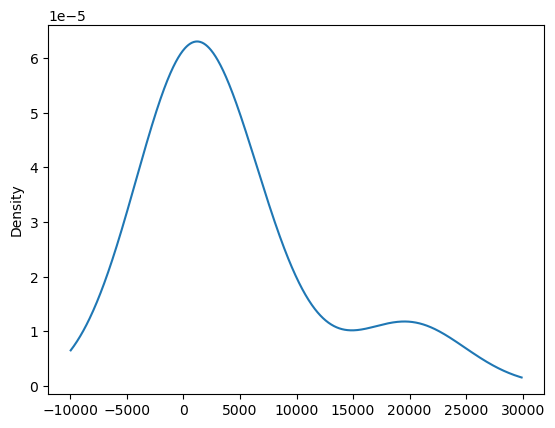

In [20]:
# Density plot of heat source values
heating_type_counts = house_data_df.heat_source.value_counts()
heating_type_counts.plot.density()

In [21]:
# Extract values with counts less than 2000 for binning
replace_heating_type = list(heating_type_counts[heating_type_counts < 2000].index)

# Replace in dataframe
for heating_type in replace_heating_type:
    house_data_df.heat_source = house_data_df.heat_source.replace(heating_type,"Solar_Other")
    
# Check to make sure binning was successful
house_data_df.heat_source.value_counts()

Gas            19930
Electricity     5852
Oil             2838
Solar_Other      168
Name: heat_source, dtype: int64

In [ ]:
# Check data types
house_data_df.dtypes

In [22]:
# Handle Ordinal Data
## Convert yes/no columns to numeric binary
house_data_df['waterfront'] = house_data_df['waterfront'].map({'YES': 1, 'NO': 0})
house_data_df['greenbelt'] = house_data_df['greenbelt'].map({'YES': 1, 'NO': 0})
house_data_df['nuisance'] = house_data_df['nuisance'].map({'YES': 1, 'NO': 0})

## Convert ordinal conlumns to numeric rank
house_data_df['view'] = house_data_df['view'].map({'NONE': 0, 'FAIR': 1, 'AVERAGE' : 2, 'GOOD' : 3, 'EXCELLENT': 4})
house_data_df['condition'] =  house_data_df['condition'].map({'Poor': 1, 'Fair': 2, 'Average': 3, 'Good': 4, 'Very Good': 5})
house_data_df['grade'] = house_data_df['grade'].map({'1 Cabin': 1, '2 Substandard': 2, '3 Poor': 3, '4 Low': 4, '5 Fair': 5,'6 Low Average': 6,'7 Average': 7,'8 Good': 8,'9 Better': 9,'10 Very Good': 10,'11 Excellent': 11,'12 Luxury': 12,'13 Mansion': 13})

In [ ]:
# check df to ensure correct categorical encoding
house_data_df

# use house_data_df as baseline for model

# Calculate education metric

In [24]:
# Calculate and append education score for each zip code
## Read in education data from Washington state data portal
school_data_df = pd.read_csv('../data/Report_Card_Assessment_Data_2021-22_School_Year (3).csv')
school_data_df

,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationId,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,SchoolOrganizationId,CurrentSchoolType,StudentGroupType,StudentGroup,GradeLevel,TestAdministration,TestSubject,Count of Students Expected to Test,Count of students expected to test including previously passed,CountMetStandard,PercentMetStandard
0,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,All,All Students,5,SBAC,ELA,1234.0,1234.0,582.0,47.20%
1,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,ELL,English Language Learners,5,SBAC,ELA,299.0,299.0,46.0,15.40%
2,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,ELL,Non-English Language Learners,5,SBAC,ELA,935.0,935.0,536.0,57.30%
3,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,Foster,Foster Care,5,SBAC,ELA,NaN,NaN,NaN,Suppressed: N<10
4,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,FRL,Non-Low Income,5,SBAC,ELA,407.0,407.0,271.0,66.60%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,Race,Hispanic/ Latino of any race(s),7,AIM,Math,NaN,NaN,NaN,Suppressed: N<10
15343,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,Race,White,7,AIM,Math,NaN,NaN,NaN,Suppressed: N<10
15344,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,Military,Non Military Parent,7,SBAC,ELA,1567.0,1567.0,1133.0,72.30%
15345,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,Race,Black/ African American,7,SBAC,ELA,NaN,NaN,NaN,37.50%


In [25]:
# Filter data by selecting all students per school segment
school_all_students_df = school_data_df.loc[school_data_df['StudentGroupType'] == 'All']
school_all_students_df

,SchoolYear,OrganizationLevel,County,ESDName,ESDOrganizationId,DistrictCode,DistrictName,DistrictOrganizationId,SchoolCode,SchoolName,SchoolOrganizationId,CurrentSchoolType,StudentGroupType,StudentGroup,GradeLevel,TestAdministration,TestSubject,Count of Students Expected to Test,Count of students expected to test including previously passed,CountMetStandard,PercentMetStandard
0,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,All,All Students,5,SBAC,ELA,1234.0,1234.0,582.0,47.20%
16,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,All,All Students,5,SBAC,Math,1240.0,1240.0,466.0,37.60%
35,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,All,All Students,5,AIM,ELA,NaN,NaN,NaN,Suppressed: N<10
47,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,All,All Students,5,AIM,Math,NaN,NaN,NaN,Suppressed: N<10
61,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,All,All Students,5,AIM,Science,NaN,NaN,NaN,Suppressed: N<10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15278,2021-22,District,King,Puget Sound Educational Service District 121,100006,17408,Auburn School District,100016,NaN,District Total,NaN,NaN,All,All Students,All Grades,WCAS,Science,3810.0,3810.0,1339.0,35.10%
15295,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,All,All Students,4,AIM,ELA,NaN,NaN,NaN,Suppressed: N<10
15321,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,All,All Students,5,SBAC,Math,1409.0,1409.0,922.0,65.40%
15326,2021-22,District,King,Puget Sound Educational Service District 121,100006,17405,Bellevue School District,100019,NaN,District Total,NaN,NaN,All,All Students,6,AIM,ELA,11.0,11.0,5.0,45.50%


In [26]:
# Groupby school district and aggregate count of tests taken
district_tests_taken = school_all_students_df.groupby(by=['DistrictCode','DistrictName'])\
['Count of students expected to test including previously passed'].sum().reset_index(name='test_taken')

In [27]:
# Groupby school district and aggregate count of students who met state education standards
district_met_standard = school_all_students_df.groupby(by='DistrictCode')['CountMetStandard']\
.sum().reset_index(name='met_standard')

In [28]:
# Merge the two groupbys to have a single df with counts of tests taken and students who met standard
merged_district_df = pd.merge(district_tests_taken, district_met_standard, on='DistrictCode')
merged_district_df

,DistrictCode,DistrictName,test_taken,met_standard
0,17001,Seattle School District No. 1,129841.0,72137.0
1,17210,Federal Way School District,53080.0,15062.0
2,17216,Enumclaw School District,10830.0,5281.0
3,17400,Mercer Island School District,10808.0,8516.0
4,17401,Highline School District,44604.0,12206.0
5,17402,Vashon Island School District,3903.0,2302.0
6,17403,Renton School District,38248.0,14099.0
7,17404,Skykomish School District,42.0,20.0
8,17405,Bellevue School District,49960.0,33901.0
9,17406,Tukwila School District,6558.0,1561.0


In [29]:
# Calculate the percent of students who met state education standards
merged_district_df['percent_met_standard'] = (merged_district_df['met_standard'] / 
                                              merged_district_df['test_taken'])

In [30]:
# Drop count columns
merged_district_df = merged_district_df.drop(columns=['met_standard','test_taken'])

In [31]:
# Rename DistrictName column for future join and drop
merged_district_df['district'] = merged_district_df['DistrictName']
merged_district_df.drop(columns='DistrictName', axis=1, inplace=True)

In [32]:
# Remove 'Scool District' from district names
merged_district_df['district'] = merged_district_df['district'].str.slice(stop=-16)
# Fix Seattle district name
merged_district_df['district'][0] = 'Seattle'
# Convert district names to all upppercase
merged_district_df['district'] = merged_district_df['district'].str.upper()

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_3175/4176883175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_district_df['district'][0] = 'Seattle'


In [34]:
# Read in school location data retrieved from country data portal
school_sites_df = pd.read_csv('../data/School_Sites_in_King_County___schsite_point.csv')
school_sites_df

,X,Y,OBJECTID,FEATURE_ID,ESITE,CODE,FEATUREDES,NAME,ABB_NAME,ADDRESS,ZIPCODE,LONG_CEN,LAT_CEN,OSPI_CODE,SCH_CLASS,DISTRICT,PIN,MAJOR,MINOR
0,-122.162518,47.726800,1,506,21186.0,660,School-Elementary,John Muir Elementary School,Muir,14012 132nd Ave NE,98034,-122.162519,47.726798,0.0,10,LAKE WASHINGTON,2226059038,222605,9038
1,-122.155785,47.371836,2,576,8603.0,660,School-Elementary,Meridian Elementary School,Meridian,25621 140th Ave SE,98042,-122.155788,47.371834,2565.0,10,KENT,2722059062,272205,9062
2,-122.030803,47.613401,3,2179,12220.0,662,School-High,Eastlake High School,Eastlake,400 228th Ave NE,98074,-122.030805,47.613399,4439.0,10,LAKE WASHINGTON,3425069021,342506,9021
3,-122.170580,47.604033,4,2156,83.0,664,School-Alternative,International School,International,445 128th Ave SE,98005,-122.170582,47.604031,3522.0,10,BELLEVUE,3325059117,332505,9117
4,-122.353646,47.664800,5,6600706,310251.0,664,School-Alternative,Northwest Montessori - Woodland Park,Northwest Montessori,4910 Phinney Ave N,98103,-122.353647,47.664799,NaN,20,SEATTLE,9521100045,952110,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649,-122.169228,47.686876,650,478,30825.0,660,School-Elementary,Mark Twain Elementary School,Twain,9525 130th Ave NE,98033,-122.169230,47.686874,0.0,10,LAKE WASHINGTON,3888100027,388810,27
650,-122.298835,47.356355,651,89,2362.0,660,School-Elementary,Mark Twain Elementary School,Twain,2450 S Star Lake Rd,98003,-122.298838,47.356353,3627.0,10,FEDERAL WAY,7204800010,720480,10
651,-122.366861,47.309363,652,326,2384.0,660,School-Elementary,Olympic View Elementary School,Olympic View,2626 SW 327th St,98023,-122.366864,47.309361,3432.0,10,FEDERAL WAY,1321039008,132103,9008
652,-122.228639,47.532462,653,544,9282.0,660,School-Elementary,Lakeridge Elementary School,Lakeridge,8215 SE 78th St,98040,-122.228641,47.532460,2981.0,10,MERCER ISLAND,2524049015,252404,9015


In [35]:
# Merge school standard and location df
district_ed_standard = school_sites_df.merge(
    merged_district_df, left_on='DISTRICT', right_on='district', suffixes=(False, False))

In [36]:
# Create new df to hold zip codes and corresponding eduction standard rates 
zip_ed_standard_df = district_ed_standard[['percent_met_standard']]
zip_ed_standard_df['zip'] = district_ed_standard['ZIPCODE']

/var/folders/wf/s7j2jn9j1ns035j4rx9g3rzr0000gn/T/ipykernel_3175/57362207.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip_ed_standard_df['zip'] = district_ed_standard['ZIPCODE']


In [37]:
# Drop duplicate zip codes 
zip_ed_standard_df = zip_ed_standard_df.drop_duplicates(subset='zip')
zip_ed_standard_df

,percent_met_standard,zip
0,0.720261,98034
1,0.720261,98074
3,0.720261,98053
7,0.720261,98033
14,0.720261,98052
...,...,...
626,0.633615,98051
629,0.690543,98045
635,0.690543,98024
648,0.589803,98070


In [38]:
# Convert zip codes to int for joing
house_data_df['zip'] = house_data_df['zip'].astype(int)

In [39]:
# Join scores table with baseline on zip
house_data_df = house_data_df.join(zip_ed_standard_df.set_index('zip'), on='zip', how='inner')
house_data_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,lat,long,renovated,month,year,zip,percent_met_standard
0,675000.0,4,1.0,1180,7140,1.0,0,0,0,0,4,7,Gas,PUBLIC,1180,0,0,40,1969,47.461975,-122.19052,0,5,2022,98055,0.368621
40,750000.0,3,2.0,1830,7969,1.0,0,0,0,0,3,7,Gas,PUBLIC,930,930,240,90,1950,47.466730,-122.21400,1,3,2022,98055,0.368621
111,728000.0,4,2.0,2170,7520,1.0,0,0,0,0,3,7,Gas,PUBLIC,1240,1240,490,60,1973,47.463930,-122.18974,0,3,2022,98055,0.368621
229,565000.0,4,2.0,1400,10364,1.5,0,0,0,0,4,6,Electricity,PUBLIC,1400,0,330,330,1971,47.448450,-122.21243,0,3,2022,98055,0.368621
308,645000.0,3,2.0,1520,8250,1.0,0,0,0,0,3,8,Gas,PUBLIC,1190,590,420,200,1981,47.460870,-122.18869,0,12,2021,98055,0.368621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,869300.0,3,2.5,3610,44686,2.0,0,0,1,0,5,7,Gas,PUBLIC,2310,1300,0,440,1923,47.708820,-121.35416,0,11,2021,98288,0.476190
24528,380000.0,2,1.0,800,9927,1.5,0,0,1,0,3,4,Electricity,PRIVATE,800,0,0,0,1981,47.712520,-121.31503,0,12,2021,98288,0.476190
26787,395000.0,1,1.0,620,10400,1.5,0,0,1,0,3,6,Electricity,PRIVATE,620,0,0,100,1981,47.712560,-121.31959,0,5,2022,98288,0.476190
28070,328000.0,2,1.5,980,5000,2.0,0,0,0,0,3,7,Electricity,PUBLIC,980,0,0,260,1922,47.707580,-121.35905,1,7,2021,98288,0.476190


# Add commuting distances here

In [40]:
# Use latlong to compute distance from each address to Amazon and University of Washington (wikipedia and geohack)

## Declare amazon coordinates
amzn_lat = 47.615144
amzn_long = -122.338578

msft_lat = 47.641944
msft_long = -122.127222

## Declare University of Washington coordinates
wash_lat = 47.654167
wash_long = -122.308056

In [41]:
# Define formulat to calculate the distances between the lat long coordinate sets
from math import sin, cos, sqrt, atan2
def haversine(lat1, lon1, lat2, lon2):

    # Calculates the Haversine distance between two points on the Earth's surface.
    R = 6371  # radius of Earth in km
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d
# Append commute distances to house_data_df
house_data_df["distance_to_amazon"] = haversine(amzn_lat, amzn_long, house_data_df["lat"], house_data_df["long"])
house_data_df["distance_to_msft"] = haversine(msft_lat, msft_long, house_data_df["lat"], house_data_df["long"])
house_data_df["distance_to_wash"] = haversine(wash_lat, wash_long, house_data_df["lat"], house_data_df["long"])

house_data_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,lat,long,renovated,month,year,zip,percent_met_standard,distance_to_amazon,distance_to_msft,distance_to_wash
0,675000.0,4,1.0,1180,7140,1.0,0,0,0,0,4,7,Gas,PUBLIC,1180,0,0,40,1969,47.461975,-122.19052,0,5,2022,98055,0.368621,20.337222,20.567735,23.119222
40,750000.0,3,2.0,1830,7969,1.0,0,0,0,0,3,7,Gas,PUBLIC,930,930,240,90,1950,47.466730,-122.21400,1,3,2022,98055,0.368621,18.968165,20.542453,22.004537
111,728000.0,4,2.0,2170,7520,1.0,0,0,0,0,3,7,Gas,PUBLIC,1240,1240,490,60,1973,47.463930,-122.18974,0,3,2022,98055,0.368621,20.187751,20.342688,22.940951
229,565000.0,4,2.0,1400,10364,1.5,0,0,0,0,4,6,Electricity,PUBLIC,1400,0,330,330,1971,47.448450,-122.21243,0,3,2022,98055,0.368621,20.814923,22.445961,23.974044
308,645000.0,3,2.0,1520,8250,1.0,0,0,0,0,3,8,Gas,PUBLIC,1190,590,420,200,1981,47.460870,-122.18869,0,12,2021,98055,0.368621,20.515316,20.656210,23.285361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,869300.0,3,2.5,3610,44686,2.0,0,0,1,0,5,7,Gas,PUBLIC,2310,1300,0,440,1923,47.708820,-121.35416,0,11,2021,98288,0.476190,74.454885,58.355343,71.668351
24528,380000.0,2,1.0,800,9927,1.5,0,0,1,0,3,4,Electricity,PRIVATE,800,0,0,0,1981,47.712520,-121.31503,0,12,2021,98288,0.476190,77.411320,61.311416,74.619532
26787,395000.0,1,1.0,620,10400,1.5,0,0,1,0,3,6,Electricity,PRIVATE,620,0,0,100,1981,47.712560,-121.31959,0,5,2022,98288,0.476190,77.073808,60.973394,74.279839
28070,328000.0,2,1.5,980,5000,2.0,0,0,0,0,3,7,Electricity,PUBLIC,980,0,0,260,1922,47.707580,-121.35905,1,7,2021,98288,0.476190,74.073905,57.975391,71.292830


In [42]:
# Export backup df for modeling
house_data_df.to_csv('../data/modeling_df.csv', index=False)

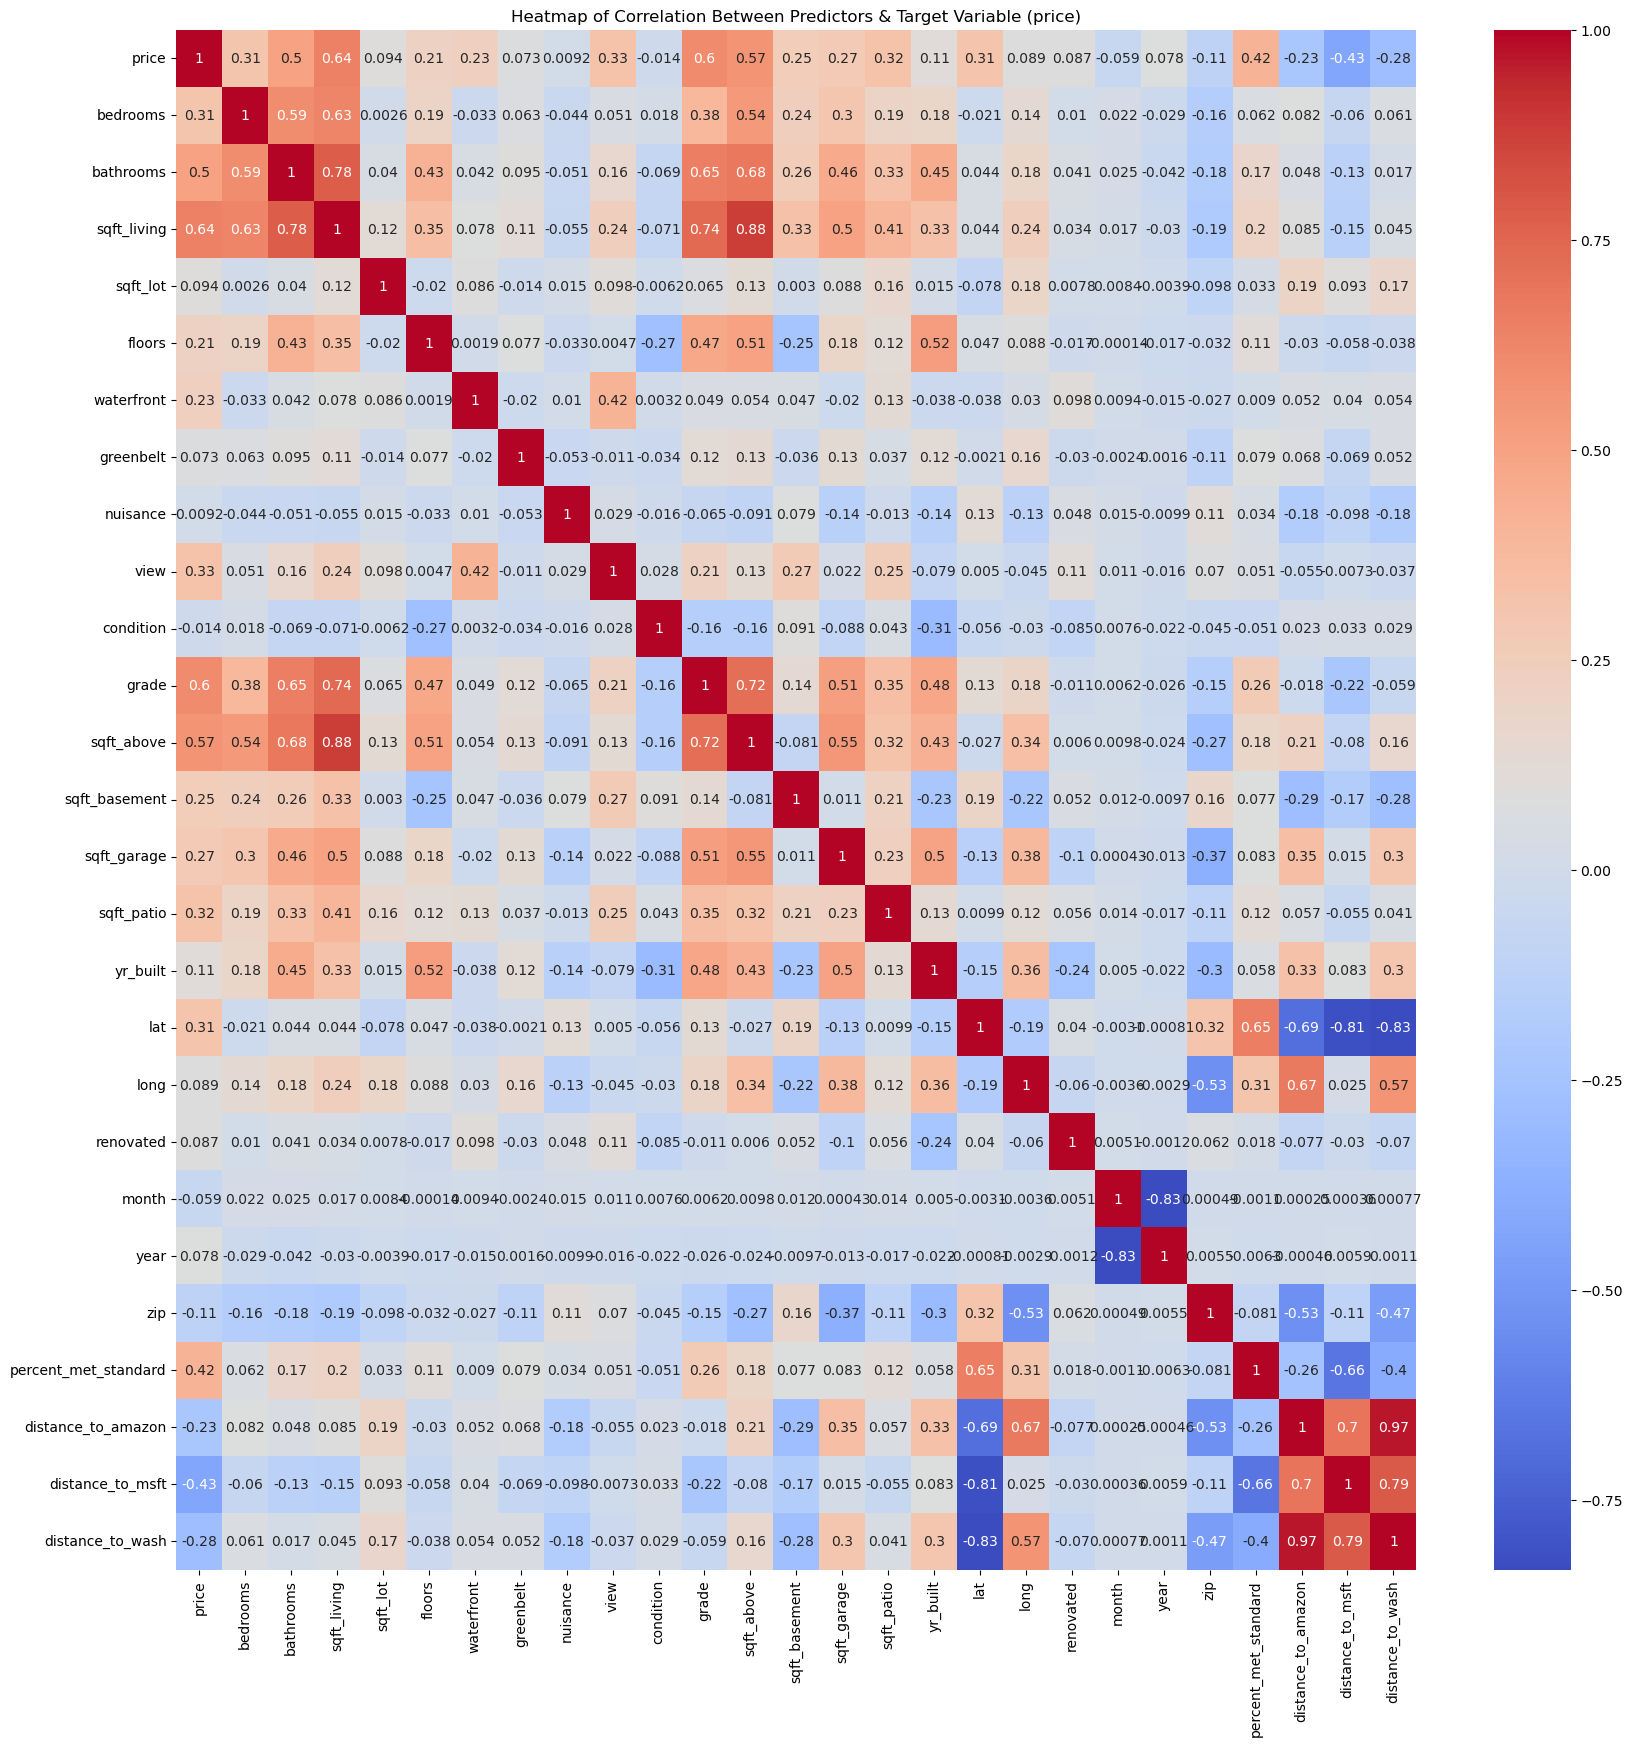

In [46]:
# set up figure size
fig, ax = plt.subplots(figsize=(20, 20))

# set up correlation matrix
corr = house_data_df.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (price)");

plt.show()


# Establish baseline with single linear regression model

## Linear Regression Model #1
### Look just at the relationship between square footage of living space and price

- X = sqft_living
- y = price

In [43]:
# Define formula for calculating regression results
def regression_results(y_test, y_pred):
    
    # Compute regression metrics
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    r2=metrics.r2_score(y_test, y_pred)
    
    # Display formatted metrics
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [44]:
# Convert living area series to np array and reshape
living_area = np.array(house_data_df['sqft_living']).reshape(-1,1)

## Declare features and target variable
X = living_area
y = house_data_df['price']

# Split the data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create LR Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
regression_results(y_test,y_pred)

In [ ]:

# Plot the data and the linear regression line
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.title('Square Footage of Living Space vs. Price')
plt.xlabel('Square Footage of Living Space')
plt.ylabel('Price in $ Millions')

# Set y ticks in millions of dollars
plt.yticks(np.arange(0, 16_000_001, 2_000_000), ['$0', '$2M', '$4M', '$6M', '$8M', '$10M', '$12M', '$14M', '$16M'])
plt.show()


<AxesSubplot: ylabel='Frequency'>

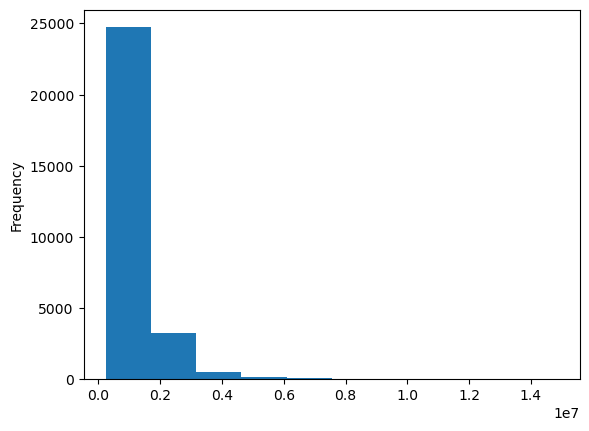

In [61]:
# Check the distributions of numeric features and identify potential outliers
house_data_df['price'].plot(kind='hist')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram
sns.histplot(data=house_data_df, x='price')

# Set the title and axes labels
plt.title('Distribution of Sale Price')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Display the plot
plt.show()

array([[<AxesSubplot: title={'center': 'price'}>,
        <AxesSubplot: title={'center': 'bedrooms'}>,
        <AxesSubplot: title={'center': 'bathrooms'}>,
        <AxesSubplot: title={'center': 'sqft_living'}>,
        <AxesSubplot: title={'center': 'sqft_lot'}>],
       [<AxesSubplot: title={'center': 'floors'}>,
        <AxesSubplot: title={'center': 'waterfront'}>,
        <AxesSubplot: title={'center': 'greenbelt'}>,
        <AxesSubplot: title={'center': 'nuisance'}>,
        <AxesSubplot: title={'center': 'view'}>],
       [<AxesSubplot: title={'center': 'condition'}>,
        <AxesSubplot: title={'center': 'grade'}>,
        <AxesSubplot: title={'center': 'sqft_above'}>,
        <AxesSubplot: title={'center': 'sqft_basement'}>,
        <AxesSubplot: title={'center': 'sqft_garage'}>],
       [<AxesSubplot: title={'center': 'sqft_patio'}>,
        <AxesSubplot: title={'center': 'yr_built'}>,
        <AxesSubplot: title={'center': 'lat'}>,
        <AxesSubplot: title={'center': '

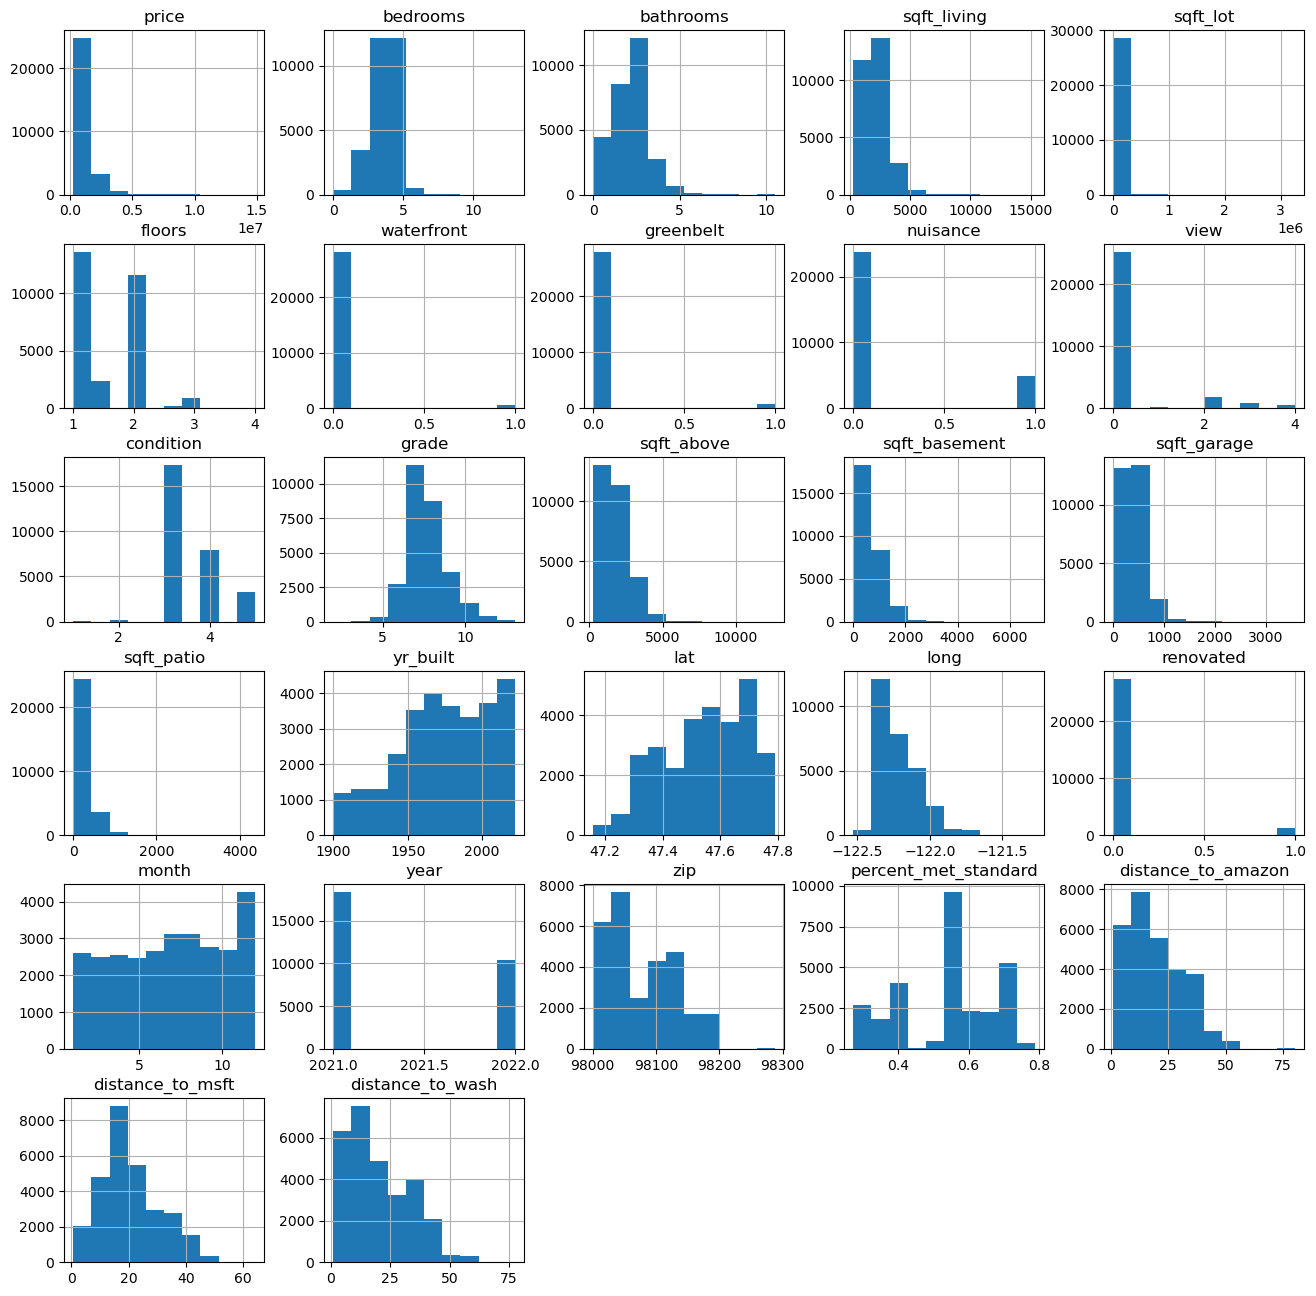

In [62]:
house_data_df.hist(figsize=(16, 16))

In [ ]:
house_data_df.boxplot(figsize=(30,30))

In [ ]:
house_data_df.describe().T.round(2)

In [ ]:
house_data_df.columns

In [ ]:
# Visualising the data using heatmap
plt.figure()
sns.heatmap(house_data_df.corr(),cmap='coolwarm')
plt.show()

## Linear Regression Model #2
### Look just at the relationship between all original numeric features and price

In [47]:
## Declare features and target variable
original_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'greenbelt', 'nuisance', 'view', 'condition', 'grade',
       'heat_source', 'sewer_system', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'lat', 'long', 'renovated']
X = house_data_df[original_features].select_dtypes(exclude=['object'])
y = house_data_df['price']

# Split the data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Create LR Model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [70]:
r2_score = metrics.r2_score(y_test, y_pred)
print("R-squared score:", r2_score)

R-squared score: 0.5535658938861743


In [ ]:
lr.coef_

In [ ]:
# Linear Regression Model #3
## Hist plots reveal skewness in price and the various sqft fiels and box plot highlights scale issues
## Use power transform to scale price and sqft fields as distributions are more logarithmic than linear

In [ ]:
# # Build feature/target arrays
# X, y = house_data_df.drop("price", axis=1), house_data_df["price"]

# # Set up the colnames
# # to_scale = []
# to_log = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
#        'sqft_garage', 'sqft_patio']
# categorical = ['heat_source', 'sewer_system']

In [ ]:
# # Declare pipelines and transformers
# # scale_pipe = make_pipeline(StandardScaler())
# log_pipe = make_pipeline(PowerTransformer())
# categorical_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))

# transformer = ColumnTransformer(
#     transformers=[
# #         ("scale", scale_pipe, to_scale),
#         ("log_transform", log_pipe, to_log),
#         ("oh_encode", categorical_pipe, categorical),]

In [ ]:
# mlr_pipe = Pipeline([("prep", transformer), ("linear_reg", LinearRegression())])

In [ ]:
house_data_df.shape

In [71]:
pt = PowerTransformer()

# Declare features and target variable
X = house_data_df.drop("price", axis=1).select_dtypes(exclude=['object'])
y = np.array(house_data_df["price"]).reshape(-1, 1)


# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit/predict/score
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [50]:
# Calculate Regression Results
def regression_results_two(y_test, y_pred):
    
    # Compute regression metrics
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_test, y_pred)
    r2=metrics.r2_score(y_test, y_pred)
    
    # Display formatted metrics
    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [73]:
regression_results_two(y_test, preds)

explained_variance:  0.7342
r2:  0.7342
MAE:  0.3566
MSE:  0.2687
RMSE:  0.5183


In [ ]:
print(lr.coef_)

In [ ]:
print(X.columns)

In [ ]:
all_num_feature_summary_df = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
print(all_num_feature_summary_df)

In [ ]:
f_values, p_values = f_regression(X, y)
print(f_values, p_values)

In [ ]:
all_num_feature_summary_df['f_values'] = f_values
all_num_feature_summary_df['p_values'] = p_values
all_num_feature_summary_df

## MLR Model #3

In [48]:
# One hot encode sewer_system and heat_source to include in next model
numeric_features_df = house_data_df.drop("price", axis=1).select_dtypes(exclude=['object'])
df_sewer_system = pd.get_dummies(house_data_df['sewer_system'], prefix='sewer_system')
df_heat_source = pd.get_dummies(house_data_df['heat_source'], prefix='heat_source')
num_and_cat_features_df = pd.concat([numeric_features_df, df_sewer_system, df_heat_source], axis=1)
num_and_cat_features_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,lat,long,renovated,month,year,zip,percent_met_standard,distance_to_amazon,distance_to_msft,distance_to_wash,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED,heat_source_Electricity,heat_source_Gas,heat_source_Oil,heat_source_Solar_Other
0,4,1.0,1180,7140,1.0,0,0,0,0,4,7,1180,0,0,40,1969,47.461975,-122.19052,0,5,2022,98055,0.368621,20.337222,20.567735,23.119222,0,0,1,0,0,1,0,0
40,3,2.0,1830,7969,1.0,0,0,0,0,3,7,930,930,240,90,1950,47.466730,-122.21400,1,3,2022,98055,0.368621,18.968165,20.542453,22.004537,0,0,1,0,0,1,0,0
111,4,2.0,2170,7520,1.0,0,0,0,0,3,7,1240,1240,490,60,1973,47.463930,-122.18974,0,3,2022,98055,0.368621,20.187751,20.342688,22.940951,0,0,1,0,0,1,0,0
229,4,2.0,1400,10364,1.5,0,0,0,0,4,6,1400,0,330,330,1971,47.448450,-122.21243,0,3,2022,98055,0.368621,20.814923,22.445961,23.974044,0,0,1,0,1,0,0,0
308,3,2.0,1520,8250,1.0,0,0,0,0,3,8,1190,590,420,200,1981,47.460870,-122.18869,0,12,2021,98055,0.368621,20.515316,20.656210,23.285361,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,3,2.5,3610,44686,2.0,0,0,1,0,5,7,2310,1300,0,440,1923,47.708820,-121.35416,0,11,2021,98288,0.476190,74.454885,58.355343,71.668351,0,0,1,0,0,1,0,0
24528,2,1.0,800,9927,1.5,0,0,1,0,3,4,800,0,0,0,1981,47.712520,-121.31503,0,12,2021,98288,0.476190,77.411320,61.311416,74.619532,1,0,0,0,1,0,0,0
26787,1,1.0,620,10400,1.5,0,0,1,0,3,6,620,0,0,100,1981,47.712560,-121.31959,0,5,2022,98288,0.476190,77.073808,60.973394,74.279839,1,0,0,0,1,0,0,0
28070,2,1.5,980,5000,2.0,0,0,0,0,3,7,980,0,0,260,1922,47.707580,-121.35905,1,7,2021,98288,0.476190,74.073905,57.975391,71.292830,0,0,1,0,1,0,0,0


In [78]:
pt = PowerTransformer()

# Declare features and target variable
X = num_and_cat_features_df
y = np.array(house_data_df["price"]).reshape(-1, 1)

# Train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit/predict/score
lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [79]:
regression_results_two(y_test, preds)

explained_variance:  0.7358
r2:  0.7358
MAE:  0.3551
MSE:  0.2671
RMSE:  0.5168


In [ ]:
num_and_cat_features_summary = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
print(num_and_cat_features_summary)
print(len(num_and_cat_features_summary))

In [ ]:
f_values, p_values = f_regression(X, y)
print(f_values, p_values)

In [ ]:
num_and_cat_features_summary['f_values'] = f_values
num_and_cat_features_summary['p_values'] = p_values
num_and_cat_features_summary

## MLR Model #4

In [51]:
# Declare features and target variable
X = num_and_cat_features_df
y = np.array(house_data_df["price"]).reshape(-1, 1)

# Apply power transformation to the relevant features
pt = PowerTransformer()
X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']] = \
pt.fit_transform(X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Make predictions on test set
preds = lr.predict(X_test)

# Evaluate model performance
regression_results_two(y_test, preds)
# Print feature coefficients, f-

explained_variance:  0.7604
r2:  0.7604
MAE:  0.334
MSE:  0.2371
RMSE:  0.4869


In [ ]:
pt_features_summary = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
f_values, p_values = f_regression(X, y)
pt_features_summary['f_values'] = f_values
pt_features_summary['p_values'] = p_values
pt_features_summary

## MLR Model #5
### Include all features & one hot encode zips

In [52]:
# One hot encode zip codes
encoded_zips_df = pd.get_dummies(num_and_cat_features_df['zip'], prefix='zip')
encoded_zips_df = pd.concat([num_and_cat_features_df, encoded_zips_df], axis=1)
encoded_zips_df = encoded_zips_df.drop(columns='zip')
encoded_zips_df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,lat,long,renovated,month,year,percent_met_standard,distance_to_amazon,distance_to_msft,distance_to_wash,sewer_system_PRIVATE,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED,heat_source_Electricity,heat_source_Gas,heat_source_Oil,heat_source_Solar_Other,zip_98001,zip_98002,zip_98003,zip_98004,zip_98005,zip_98006,zip_98007,zip_98008,zip_98010,zip_98011,zip_98014,zip_98019,zip_98022,zip_98023,zip_98024,zip_98027,zip_98028,zip_98029,zip_98030,zip_98031,zip_98032,zip_98033,zip_98034,zip_98038,zip_98039,zip_98040,zip_98042,zip_98045,zip_98047,zip_98051,zip_98052,zip_98053,zip_98055,zip_98056,zip_98057,zip_98058,zip_98059,zip_98065,zip_98070,zip_98072,zip_98074,zip_98075,zip_98077,zip_98092,zip_98102,zip_98103,zip_98105,zip_98106,zip_98107,zip_98108,zip_98109,zip_98112,zip_98115,zip_98116,zip_98117,zip_98118,zip_98119,zip_98122,zip_98125,zip_98126,zip_98133,zip_98136,zip_98144,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199,zip_98288
0,4,1.0,-1.128974,-0.047621,1.0,0,0,0,0,4,7,-0.741034,-0.961545,-1.319619,-0.602154,1969,47.461975,-122.19052,0,5,2022,0.368621,20.337222,20.567735,23.119222,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,3,2.0,-0.149381,0.069354,1.0,0,0,0,0,3,7,-1.328905,1.042142,-0.089747,-0.224218,1950,47.466730,-122.21400,1,3,2022,0.368621,18.968165,20.542453,22.004537,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
111,4,2.0,0.238898,0.007790,1.0,0,0,0,0,3,7,-0.621962,1.104603,0.633727,-0.428706,1973,47.463930,-122.18974,0,3,2022,0.368621,20.187751,20.342688,22.940951,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
229,4,2.0,-0.750731,0.342811,1.5,0,0,0,0,4,6,-0.335547,-0.961545,0.187030,0.741956,1971,47.448450,-122.21243,0,3,2022,0.368621,20.814923,22.445961,23.974044,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
308,3,2.0,-0.567239,0.105935,1.0,0,0,0,0,3,8,-0.720692,0.940889,0.444291,0.303193,1981,47.460870,-122.18869,0,12,2021,0.368621,20.515316,20.656210,23.285361,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,3,2.5,1.425274,1.697747,2.0,0,0,1,0,5,7,0.772221,1.114751,-1.319619,1.039444,1923,47.708820,-121.35416,0,11,2021,0.476190,74.454885,58.355343,71.668351,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24528,2,1.0,-1.973053,0.298606,1.5,0,0,1,0,3,4,-1.714643,-0.961545,-1.319619,-1.453448,1981,47.712520,-121.31503,0,12,2021,0.476190,77.411320,61.311416,74.619532,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
26787,1,1.0,-2.514901,0.346359,1.5,0,0,1,0,3,6,-2.392582,-0.961545,-1.319619,-0.165024,1981,47.712560,-121.31959,0,5,2022,0.476190,

In [53]:
# Declare features and target variable
X = encoded_zips_df
y = np.array(house_data_df["price"]).reshape(-1, 1)

# Apply power transformation to the relevant features
pt = PowerTransformer()
X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']] = \
pt.fit_transform(X[['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Make predictions on test set
preds = lr.predict(X_test)

# Evaluate model performance
regression_results_two(y_test, preds)

explained_variance:  0.7961
r2:  0.7961
MAE:  0.2937
MSE:  0.2018
RMSE:  0.4492


In [ ]:
all_features_summary = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
f_values, p_values = f_regression(X, y)
all_features_summary['f_values'] = f_values
all_features_summary['p_values'] = p_values
all_features_summary

## MLR Model #6
### Include all features & one hot encode zips

In [40]:
X.columns

NameError: name 'X' is not defined

In [54]:
# Declare features and target variable
X = encoded_zips_df
y = np.array(house_data_df["price"]).reshape(-1, 1)

# Apply power transformation to the relevant features
pt = PowerTransformer()
ss = StandardScaler()
columns_to_pt = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']

X[columns_to_pt] = pt.fit_transform(X[columns_to_pt])

columns_to_ss = list(set(encoded_zips_df.columns) - set(columns_to_pt))
X[columns_to_ss] = ss.fit_transform(X[columns_to_ss])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Make predictions on test set
preds = lr.predict(X_test)

# Evaluate model performance
regression_results_two(y_test, preds)

explained_variance:  0.7961
r2:  0.7961
MAE:  0.2938
MSE:  0.2018
RMSE:  0.4492


In [57]:

# plots TESTING set & residuals
fig, axes = plt.subplots(1, 2, figsize=(8, 8))

# plots regplots
sns.regplot(ax = axes[0], 
            x = np.exp(preds), 
            y = np.exp(y_test),
            scatter_kws={'s':5, 'alpha': 0.2, 'color': 'darkgreen'},
            line_kws={"color": "red"})

# annotate regplot
axes[0].text(0.20*10**6, 4.1*10**6, "Testing R2 = 0.868", 
             horizontalalignment='left', fontsize=13, color='black', weight = 'bold')
# regplot labels
axes[0].set_xlabel('Predicted Testing Price', weight = 'bold') 
axes[0].set_ylabel('Actual Testing Price', weight = 'bold') 
axes[0].set_title('Predicted Testing Price VS. Actual', weight = 'bold', fontdict = {'fontsize' : 15})

# plots residual
sns.scatterplot(ax = axes[1], 
                x = range(y_test.shape[0]),
                y = residuals_test, 
                alpha=0.1,
                color= "darkgreen")
# plot zero line in residual
sns.lineplot(ax = axes[1], 
             x=range(y_test.shape[0]), y = 0, 
             color='red', linestyle="dashed", linewidth = 3)
# residual labels
axes[1].set_xlabel('Count', weight = 'bold') 
axes[1].set_ylabel('Price Residuals', weight = 'bold') 
axes[1].set_title('Testing Set Residuals', weight = 'bold', fontdict = {'fontsize' : 15})

# removes top and right side axis
sns.despine(right = True)

# set gridline visibility
axes[0].set_axisbelow(True)
axes[0].yaxis.grid(True, color='#EEEEEE')
axes[0].xaxis.grid(False)
axes[1].set_axisbelow(True)
axes[1].yaxis.grid(True, color='#EEEEEE')
axes[1].xaxis.grid(False)

plt.show()
# fig.savefig('images/testingset.png');

NameError: name 'residuals_test' is not defined

ValueError: Image size of 1060626x55683587 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x800 with 2 Axes>

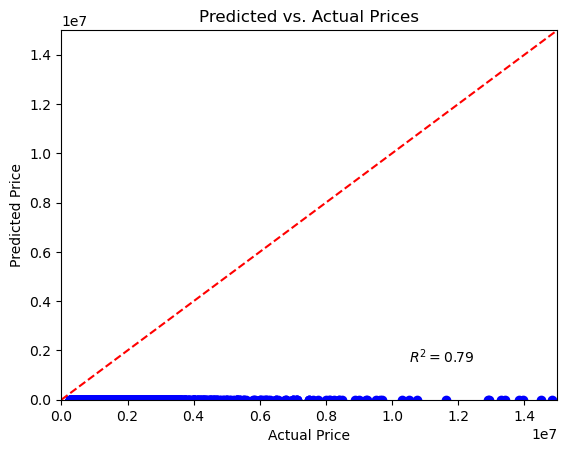

In [85]:
# Scale back data for plotting
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
plt.ticklabel_format(useOffset=False)
## Convert predicted and actual prices back to original scale .flatten()
y_test_orig = pt.inverse_transform(y_test)
y_pred_orig = pt.inverse_transform(preds)

## Plot predicted vs actual prices
plt.scatter(y_test_orig, preds, color='blue')
plt.plot([0, 15000000], [0, 15000000], color='red', linestyle='--')
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.ticklabel_format(useOffset=False)
# Set the x and y axis limits
plt.xlim(0, 15_000_000)
plt.ylim(0, 15_000_000)
## Show R^2 score in the plot
r2 = 0.7928
plt.text(0.7 * 15_000_000, 0.1 * 15_000_000, f'$R^2={r2:.2f}$')
plt.show()

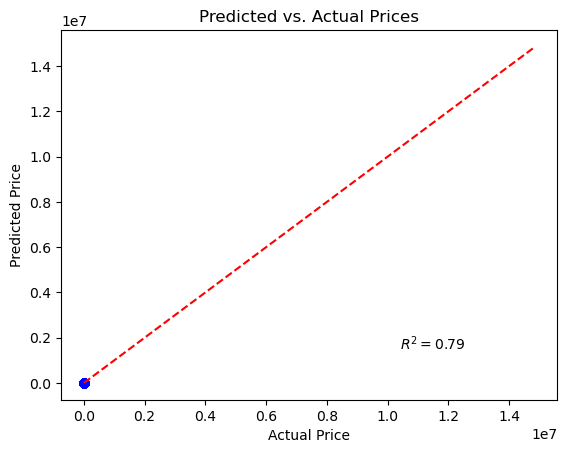

In [53]:
# Plot the predicted vs. actual prices
plt.scatter(y_test, preds, color='blue')
plt.plot([0, np.max(y)], [0, np.max(y)], color='red', linestyle='--')
plt.title('Predicted vs. Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
# Show the R^2 score in the plot
r2 = metrics.r2_score(y_test, preds)
plt.text(0.7 * np.max(y), 0.1 * np.max(y), f'$R^2={r2:.2f}$')
plt.show()

In [88]:
all_features_scaled_summary = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
f_values, p_values = f_regression(X, y)
all_features_scaled_summary['f_values'] = f_values
all_features_scaled_summary['p_values'] = p_values
pd.set_option("display.max_rows", None)
all_features_scaled_summary

/Users/jamesbenasuli/miniforge3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Coefficients,f_values,p_values
bedrooms,2.251798e-03,3057.699367,0.000000e+00
bathrooms,4.725507e-02,9828.901795,0.000000e+00
sqft_living,2.108902e-01,12997.904279,0.000000e+00
sqft_lot,2.240388e-01,1283.486128,4.985036e-275
floors,1.570020e-02,1300.969806,1.152779e-278
waterfront,5.564422e-02,1579.146251,0.000000e+00
greenbelt,1.398573e-02,151.874473,8.265469e-35
nuisance,-3.263784e-02,2.451352,1.174347e-01
view,7.484113e-02,3404.806502,0.000000e+00
condition,8.455686e-02,5.764904,1.635570e-02


In [ ]:
pd.reset_option("display.max_rows")

In [49]:
# Declare features and target variable
X = encoded_zips_df
y = np.array(house_data_df["price"]).reshape(-1, 1)

# Apply power transformation to the relevant features
pt = PowerTransformer()
ss = StandardScaler()
columns_to_pt = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']

X[columns_to_pt] = pt.fit_transform(X[columns_to_pt])

columns_to_ss = list(set(encoded_zips_df.columns) - set(columns_to_pt))
X[columns_to_ss] = ss.fit_transform(X[columns_to_ss])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Make predictions on test set
preds = lr.predict(X_test)

# Evaluate model performance
regression_results_two(y_test, preds)

explained_variance:  0.7928
r2:  0.7928
MAE:  0.2989
MSE:  0.2094
RMSE:  0.4576


In [59]:
all_features_scalled_summary = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
f_values, p_values = f_regression(X, y)
all_features_scalled_summary['f_values'] = f_values
all_features_scalled_summary['p_values'] = p_values
all_features_scalled_summary.to_csv('p_values.csv')

/Users/jamesbenasuli/miniforge3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Drop all one hot categorical features

In [45]:
# Declare features and target variable
X = house_data_df.drop(["price", "zip"], axis=1).select_dtypes(exclude=['object'])
y = np.array(house_data_df["price"]).reshape(-1, 1)

# Apply power transformation to the relevant features
pt = PowerTransformer()
ss = StandardScaler()
columns_to_pt = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']

X[columns_to_pt] = pt.fit_transform(X[columns_to_pt])

columns_to_ss = list(set(X.columns) - set(columns_to_pt))
X[columns_to_ss] = ss.fit_transform(X[columns_to_ss])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Encode the target
y_train = pt.fit_transform(y_train)
y_test = pt.transform(y_test)

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Make predictions on test set
preds = lr.predict(X_test)

# Evaluate model performance
regression_results_two(y_test, preds)

no_cat_features_summary = pd.DataFrame(np.array(lr.coef_).reshape(-1,1), X.columns, columns=['Coefficients'])
f_values, p_values = f_regression(X, y)
no_cat_features_summary['f_values'] = f_values
no_cat_features_summary['p_values'] = p_values
no_cat_features_summary

explained_variance:  0.7484
r2:  0.7484
MAE:  0.344
MSE:  0.2543
RMSE:  0.5043


/Users/jamesbenasuli/miniforge3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Coefficients,f_values,p_values
bedrooms,-0.008109,3057.699367,0.000000e+00
bathrooms,0.061077,9828.901795,0.000000e+00
sqft_living,0.203905,12983.376162,0.000000e+00
sqft_lot,0.147498,1275.856505,1.927560e-273
floors,0.015489,1300.969806,1.152779e-278
waterfront,0.053369,1579.146251,0.000000e+00
greenbelt,0.016122,151.874473,8.265469e-35
nuisance,-0.031841,2.451352,1.174347e-01
view,0.085033,3404.806502,0.000000e+00
condition,0.078679,5.764904,1.635570e-02


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from numpy import log1p

# Create a histogram of house price data
plt.hist(log1p(house_data_df['sqft_living']), bins=30, density=True, alpha=0.5)

# Set the title and axis labels
plt.title('Distribution of Log of Square Footage')
plt.xlabel('Log of Square Footage')
plt.ylabel('Frequency')

# Display the plot
plt.show()